## TicTacToe with Actor-Critic

Set import path to ../src for common function and classes.

In [36]:
import sys

sys.path.append("../src")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Determine Device

In [ ]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Import necessary libraries

import random
import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.distributions import Categorical
from pettingzoo.classic import tictactoe_v3

from itertools import count
import seaborn as sns
import shutil

import matplotlib.pyplot as plt

import cv2
import imageio

from utils import show
from base_agent import BaseAgent
from replay_memory import ReplayMemory
from summary_writer import LocalSummaryWriter


In [39]:
class ActorNetwork(nn.Module):
    """Actor Network for the policy gradient method."""

    def __init__(self, state_size, action_size):
        super(ActorNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        """Forward pass through the network."""
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


In [40]:
class CriticNetwork(nn.Module):
    """Critic Network for Policy Gradient."""

    # The critic network is used to estimate the value function.
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        """Forward pass through the network."""
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [41]:
class A2CAgent(BaseAgent):
    """Agent class for the Actor-Critic algorithm."""

    def __init__(
        self,
        env: gym.Env,
        gamma=0.99,
        lr=5e-4,
        buffer_size=int(1e5),
        batch_size=100,
        learn_every=4,
        writer=None,
        seed=42,
    ):
        super(A2CAgent, self).__init__(env=env)
        self.action_size = 9
        self.state_size = 9
        self.learn_every = learn_every
        self.batch_size = batch_size
        self.gamma = gamma
        self.actor = ActorNetwork(self.state_size, self.action_size).to(device)
        self.critic = CriticNetwork(self.state_size, self.action_size).to(device)
        self.optimizerA = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizerC = optim.Adam(self.critic.parameters(), lr=lr)
        self.memory = ReplayMemory(buffer_size)
        self.learn_step = 0
        self.writer = writer
        self.plots = {"Loss": [], "Epsilon": [], "Reward": [], "Mean Reward": []}
        self.seed = seed

    def compute_returns(self, next_value, rewards, masks, gamma=0.99):
        """Compute the returns for the given rewards and masks."""
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + gamma * R * masks[step]
            returns.insert(0, R)
        return returns

    def state_preprocess(self, obs: any, num_states: int):
        board = obs["observation"]
        board_processed = board[:, :, 0] - board[:, :, 1]
        return board_processed.flatten()

    def detect_winner(self, obs: any):
        board = obs["observation"].reshape(3, 3, 2)
        board = board.argmax(axis=2)  # 0 for X, 1 for O, 2 = empty
        for player, label in [(0, "player_1"), (1, "player_2")]:
            for i in range(3):
                if all(board[i, :] == player):
                    return label
                if all(board[:, i] == player):
                    return label
            if all(np.diag(board) == player):
                return label
            if all(np.diag(np.fliplr(board)) == player):
                return label

        return None

    def act(self, state):
        """Select an action based on the current state."""
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        action = dist.sample()

        return action.item(), dist.log_prob(action)

    def step(self, action: int) -> tuple[int, any, Tensor, bool, bool]:
        """Take a step in the environment."""
        state, reward, done, terminated, _ = self.env.step(action)
        return (
            state,
            reward,
            done,
            terminated,
        )

    def optimize(self):
        """Sample a batch of experiences and update the actor and critic networks."""
        pass

    # Training loop
    def train(self, num_episodes=500, smooth=100):
        """Train the agent."""
        smoothed_reward = []
        raw_reward = []
        elapsed_times = []
        mean_reward = 0
        for episode in range(num_episodes):
            self.env.reset(seed=self.seed)
            obs, reward, done, truncation, info = self.env.last()
            state = self.state_preprocess(obs, num_states=self.state_size)

            action_state_hist = []
            log_probs = []
            values = []
            rewards = []
            masks = []
            entropy = 0
            total_reward = 0
            start_time = time.time()

            for i in count():
                dist, q_value = (
                    self.actor(torch.tensor(state, dtype=torch.float32, device=device)),
                    self.critic(torch.tensor(state, dtype=torch.float32, device=device)),
                )
                valid_moves = np.where(state == 0)[0]
                action = dist.sample()
                while action.item() not in valid_moves:
                    action = dist.sample()
                # print(f"Chosen action: {action.item()}")

                self.env.step(action.item())
                obs, reward, done, terminate, info = self.env.last()
                next_state = self.state_preprocess(obs, self.state_size)

                # Self-play with random opponent
                if not done and not truncation:
                    # Save DQN Agent action history
                    action_state_hist.append((action, state, next_state, reward, done))

                    # Get valid moves for the opponent
                    valid_moves = np.where(next_state == 0)[0]
                    # Exploration: Choose random valid move
                    opponent_action = int(np.random.choice(valid_moves))
                    # print(f"(Exploring) Chosen opponent action: {opponent_action}")
                    self.env.step(opponent_action)
                    obs, reward, done, truncation, info = self.env.last()
                    next_state = self.state_preprocess(obs, num_states=self.state_size)

                log_prob = dist.log_prob(action).unsqueeze(0)
                entropy += dist.entropy().mean()

                log_probs.append(log_prob)
                values.append(q_value)
                rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
                masks.append(torch.tensor([1 - done], dtype=torch.float, device=device))
                total_reward += reward
                state = next_state
                end_time = time.time()
                if done or terminate:
                    last_observation, reward, done, truncation, info = self.env.last()
                    elapsed_time = end_time - start_time
                    # print("Iteration: {}, Score: {}".format(episode, i))
                    break

            winner = self.detect_winner(last_observation)
            # print(f"Winner: {winner}")
            final_reward = 1 if winner == "player_1" else -1 if winner == "player_2" else 0
            # Update rewards
            for i in range(len(rewards)):
                rewards[i] = torch.tensor([final_reward], dtype=torch.float, device=device)

            next_value = self.critic(torch.tensor(next_state, dtype=torch.float32, device=device))
            returns = self.compute_returns(next_value, rewards, masks, self.gamma)

            log_probs = torch.cat(log_probs)
            returns = torch.cat(returns).detach()
            values = torch.cat(values)

            advantage = returns - values

            actor_loss = -(log_probs * advantage.detach()).mean()
            critic_loss = advantage.pow(2).mean()

            self.optimizerA.zero_grad()
            self.optimizerC.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.optimizerA.step()
            self.optimizerC.step()

            elapsed_times.append(elapsed_time)
            raw_reward.append(final_reward)
            smoothed_reward.append(final_reward)
            if len(smoothed_reward) > smooth:
                smoothed_reward = smoothed_reward[-1 * smooth : -1]

            mean_reward = np.mean(smoothed_reward)

            self.writer.add_scalar("Reward", final_reward, episode)
            self.writer.add_scalar("Mean Reward", np.mean(smoothed_reward), episode)

            self.plots["Reward"].append(final_reward)
            self.plots["Mean Reward"].append(mean_reward)

            if episode % 100 == 0:
                print(
                    "\tEpisode {} \t Latest Reward {:.2f} \t Average Reward: {:.2f}".format(
                        episode, final_reward, np.mean(smoothed_reward)
                    )
                )

        print(
            "\tEpisode {} \t Final Reward {:.2f} \t Average Reward: {:.2f}".format(
                num_episodes, final_reward, np.mean(smoothed_reward)
            )
        )
        return elapsed_times, raw_reward, smoothed_reward

    def run(self):
        """Run/test the agent in the environment."""
        self.load()

        self.env.reset(seed=self.seed)
        obs, _, done, truncation, info = self.env.last()
        state = self.state_preprocess(obs, num_states=self.state_size)

        step_size = 0
        episode_reward = 0
        frames = []

        frame = self.env.render()
        frames.append(frame)
        while not done and not truncation:
            dist = self.actor(torch.tensor(state, dtype=torch.float32, device=device))
            valid_moves = np.where(state == 0)[0]
            action = dist.sample()
            while action.item() not in valid_moves:
                action = dist.sample()

            self.env.step(action.item())
            obs, _, done, truncation, info = self.env.last()
            state = self.state_preprocess(obs, num_states=self.state_size)

            # Self-play with random opponent
            if not done and not truncation:
                # Get valid moves for the opponent
                valid_moves = np.where(state == 0)[0]
                # Exploration: Choose random valid move
                opponent_action = int(np.random.choice(valid_moves))
                # print(f"(Exploring) Chosen opponent action: {opponent_action}")
                self.env.step(opponent_action)
                obs, _, done, truncation, info = self.env.last()
                state = self.state_preprocess(obs, num_states=self.state_size)

            step_size += 1

            frame = self.env.render()
            frames.append(frame)

        winner = self.detect_winner(self.env.last()[0])
        print(f"Winner: {winner}")
        episode_reward = 1 if winner == "player_1" else -1 if winner == "player_2" else 0

        # Print log
        result = f"Steps: {step_size:}, Reward: {episode_reward:.2f}, "
        print(result)

        print("\tSaving Animation ...")

        video_path = "%s/tictactoe-movie.mp4" % self.writer.log_dir
        fps = 30
        imageio.mimsave(video_path, frames, fps=fps)

        video = cv2.VideoCapture(video_path)

        frame_per_second = video.get(cv2.CAP_PROP_FPS)
        assert frame_per_second == fps, f"FPS should be {fps} but got {frame_per_second}"
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

        return frame_count / frame_per_second if frame_per_second > 0 else 0, episode_reward

    def plot(self):
        """Plot the training results."""
        sns.set()
        sns.set_context("poster")

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Reward"])), self.plots["Reward"], label="Reward")
        plt.plot(
            np.arange(len(self.plots["Mean Reward"])),
            self.plots["Mean Reward"],
            label="Mean Reward",
        )
        plt.legend()
        plt.title("ACM Gradient Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.savefig("%s/plot_%s.png" % (self.writer.log_dir, "rewards"))

    def save(self):
        """Save the model."""
        torch.save(self.actor.state_dict(), "%s/model.pt" % self.writer.log_dir)

    def load(self):
        """Load the model."""
        self.actor.load_state_dict(torch.load("%s/model.pt" % self.writer.log_dir))
        self.actor.eval()

    def set_writer(self, writer: LocalSummaryWriter):
        """Set the summary writer."""
        self.writer = writer

In [ ]:
def main(RL_hyperparams):
    """Train and Run the DQN agent."""
    torch.manual_seed(RL_hyperparams["random_seed"])
    np.random.seed(RL_hyperparams["random_seed"])
    random.seed(RL_hyperparams["random_seed"])

    rewards = []
    run_times = []
    for i in range(1, RL_hyperparams["number_of_experiments"] + 1):
        print("[Experiment]\t{} of {}".format(i, RL_hyperparams["number_of_experiments"]))

        path = f"../experiments/a2c_tictactoe/run-{i}"
        shutil.rmtree(path, ignore_errors=True)

        writer = LocalSummaryWriter(path)
        writer.add_parameters(RL_hyperparams)

        if i == 1:
            print("[Env]\tCreating Environment ...")
            env = tictactoe_v3.env(render_mode="human" if RL_hyperparams["render"] else "rgb_array")
            env.reset()

            runner = A2CAgent(
                env,
                seed=RL_hyperparams["random_seed"],
                batch_size=RL_hyperparams["batch_size"],
                lr=RL_hyperparams["lr"],
                gamma=RL_hyperparams["gamma"],
                learn_every=RL_hyperparams["learn_every"],
                writer=writer,
            )

            print("[Train]\tTraining Beginning ...")
            train_times, train_rewards, _ = runner.train(RL_hyperparams["num_episodes"])

            print("[Plot]\tPlotting Training Curves ...")
            runner.plot()

            print("[Save]\tSaving Model ...")
            runner.save()
        else:
            runner.set_writer(writer)
            runner.save()

        print("[Run]\tRunning Simulation ...")
        run_time, reward = runner.run()
        rewards.append(reward)
        run_times.append(run_time)

        print("[Video]\tShow Video ...")
        video_path = "%s/tictactoe-movie.mp4" % path
        show(video_path)

    print("[End]\tDone. Congratulations!")

    shutil.copyfile("../experiments/a2c_tictactoe/run-1/model.pt", "./tictactoe_acm_model.pt")

    print("[Reward]\tAverage Reward: ", np.mean(rewards))
    print("[Reward]\tStandard Deviation of Reward: ", np.std(rewards))
    print("[Reward]\tMax Reward: ", np.max(rewards))
    print("[Reward]\tMin Reward: ", np.min(rewards))
    print("[Reward]\tWins: ", (np.asarray(rewards) == 1).sum())
    print("[Reward]\tLosses: ", (np.asarray(rewards) == -1).sum())
    print("[Reward]\tDraws: ", (np.asarray(rewards) == 0).sum())

    print("[RunTime]\tAverage Run Time: ", np.mean(run_times))
    print("[RunTime]\tStandard Deviation of Run Time: ", np.std(run_times))
    print("[RunTime]\tMax Run Time: ", np.max(run_times))
    print("[RunTime]\tMin Run Time: ", np.min(run_times))

    print("[TrainingTime]\tAverage Training Time: ", np.mean(train_times))
    print("[TrainingTime]\tMax Training Time: ", np.max(train_times))
    print("[TrainingTime]\tMin Training Time: ", np.min(train_times))

    print("[TrainingReward]\tAverage Training Reward: ", np.mean(train_rewards))
    print("[TrainingReward]\tMax Training Rewards: ", np.max(train_rewards))
    print("[TrainingReward]\tMin Training Rewards: ", np.min(train_rewards))

[Experiment]	1 of 50
[Env]	Creating Environment ...
[Train]	Training Beginning ...
	Episode 0 	 Latest Reward 1.00 	 Average Reward: 1.00
	Episode 100 	 Latest Reward 1.00 	 Average Reward: 0.00
	Episode 200 	 Latest Reward 1.00 	 Average Reward: 0.11
	Episode 300 	 Latest Reward -1.00 	 Average Reward: 0.06
	Episode 400 	 Latest Reward -1.00 	 Average Reward: -0.02
	Episode 500 	 Latest Reward -1.00 	 Average Reward: 0.07
	Episode 600 	 Latest Reward 1.00 	 Average Reward: 0.15
	Episode 700 	 Latest Reward 1.00 	 Average Reward: 0.13
	Episode 800 	 Latest Reward 1.00 	 Average Reward: 0.10
	Episode 900 	 Latest Reward 1.00 	 Average Reward: 0.15
	Episode 1000 	 Latest Reward 1.00 	 Average Reward: 0.06
	Episode 1100 	 Latest Reward 1.00 	 Average Reward: 0.09
	Episode 1200 	 Latest Reward 1.00 	 Average Reward: 0.11
	Episode 1300 	 Latest Reward -1.00 	 Average Reward: -0.03
	Episode 1400 	 Latest Reward -1.00 	 Average Reward: 0.12
	Episode 1500 	 Latest Reward 1.00 	 Average Reward:

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[Save]	Saving Model ...
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	2 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	3 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	4 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Winner: player_2
Steps: 5, Reward: -1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=6.0
duration=0.2
[Experiment]	5 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	6 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	7 of 50
[Run]	Running Simulation ...
Winner: player_2
Steps: 4, Reward: -1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	8 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	9 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	10 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	11 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Winner: player_2
Steps: 5, Reward: -1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=6.0
duration=0.2
[Experiment]	12 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	13 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	14 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	15 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	16 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	17 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	18 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	19 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	20 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	21 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	22 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	23 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Winner: player_2
Steps: 5, Reward: -1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=6.0
duration=0.2
[Experiment]	24 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	25 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	26 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	27 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	28 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	29 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	30 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	31 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	32 of 50
[Run]	Running Simulation ...
Winner: player_2
Steps: 5, Reward: -1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=6.0
duration=0.2
[Experiment]	33 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	34 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	35 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	36 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	37 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	38 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	39 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	40 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Winner: player_2
Steps: 5, Reward: -1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=6.0
duration=0.2
[Experiment]	41 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	42 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	43 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Winner: None
Steps: 5, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=6.0
duration=0.2
[Experiment]	44 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	45 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	46 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	47 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 3, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=4.0
duration=0.13333333333333333
[Experiment]	48 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	49 of 50
[Run]	Running Simulation ...
Winner: player_1
Steps: 4, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[Experiment]	50 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Winner: player_2
Steps: 4, Reward: -1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=5.0
duration=0.16666666666666666
[End]	Done. Congratulations!
[Reward]	Average Reward:  0.7
[Reward]	Standard Deviation of Reward:  0.7
[Reward]	Max Reward:  1
[Reward]	Min Reward:  -1
[Reward]	Wins:  42
[Reward]	Losses:  7
[Reward]	Draws:  1
[RunTime]	Average Run Time:  0.16133333333333333
[RunTime]	Standard Deviation of Run Time:  0.02039607805437114
[RunTime]	Max Run Time:  0.2
[RunTime]	Min Run Time:  0.13333333333333333
[TrainingTime]	Average Training Time:  0.0016586071252822877
[TrainingTime]	Max Training Time:  0.4533989429473877
[TrainingTime]	Min Training Time:  0.0005109310150146484
[TrainingReward]	Average Training Reward:  0.1675
[TrainingReward]	Max Training Rewards:  1
[TrainingReward]	Min Training Rewards:  -1


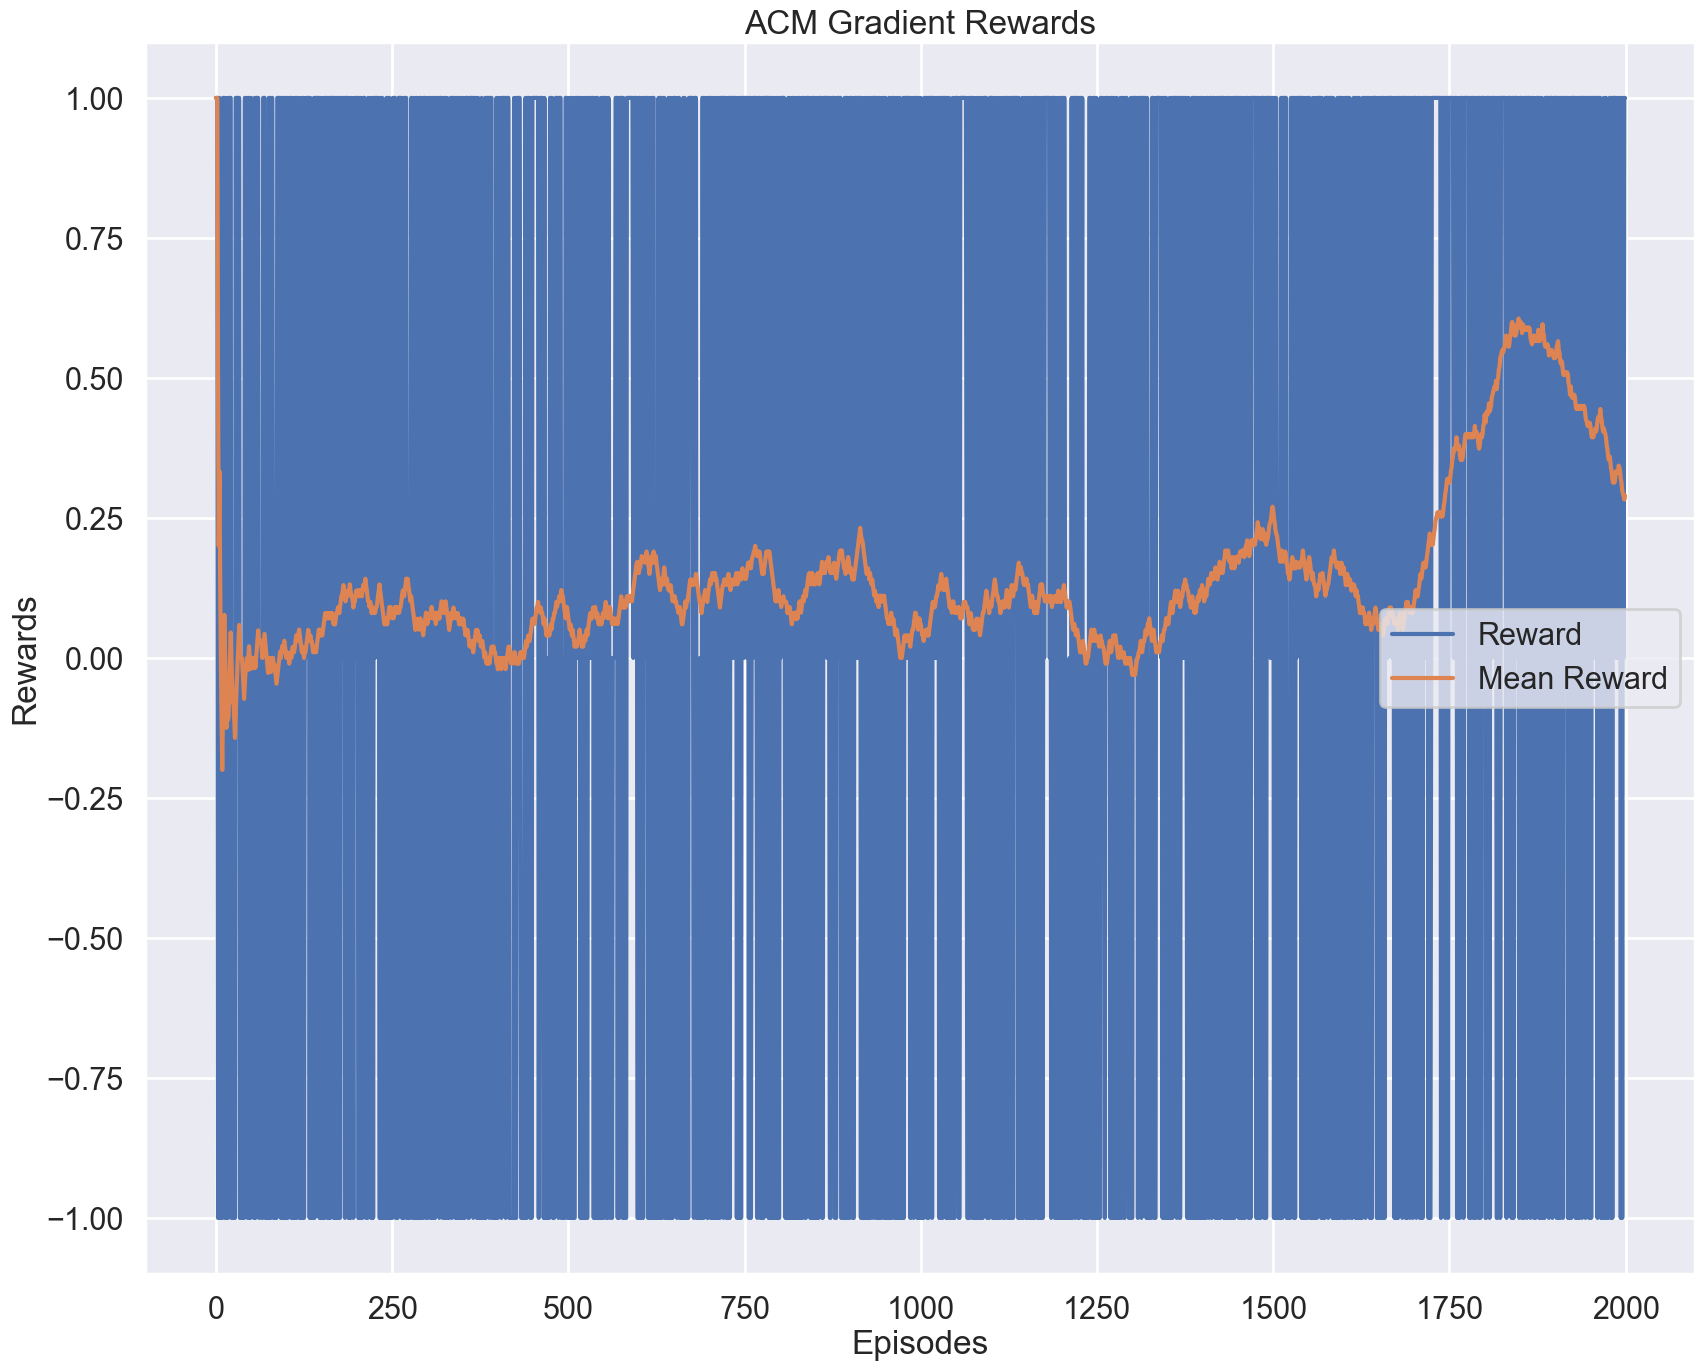

In [46]:
if __name__ == "__main__":
    RL_hyperparams = {
        "number_of_experiments": 50,
        "num_episodes": 2000,
        "lr": 1e-4,
        "eps_start": 0.999,
        "eps_end": 0.01,
        "eps_decay": 0.999,
        "gamma": 0.999,
        "batch_size": 32,
        "learn_every": 4,
        "random_seed": 42,
        "render": False,
    }

    main(RL_hyperparams=RL_hyperparams)